# Double DQN && Dueling DQN

本次作业包含3个代码填空和1个Exercise。

# 简介
DQN算法敲开了用深度神经网络构建Q函数的大门，但是作为先驱性的工作，其本身也存在着一些问题以及一些可以改进的地方，于是在DQN之后学术界涌现出了非常多的改进算法。在本节课程中，我们将介绍其中两个非常著名的算法：Double DQN和Dueling DQN，这两个算法实现简单但能一定程度改善DQN的效果。如果想要了解更加详细的各种DQN改进方法，我们推荐读者阅读论文[1]以及其中的引用文献。

[1] Hessel, Matteo, et al. "[Rainbow: Combining improvements in deep reinforcement learning.](https://arxiv.org/abs/1710.02298)" arXiv preprint arXiv:1710.02298 (2017).

# Double DQN

传统的DQN算法通常会导致对Q值的过高估计。我们可以观察到，传统DQN优化的目标为
$$
r+\gamma \max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)
$$
这个目标由目标网络（参数为$\theta^-$）计算得出，我们还可以将其写成如下形式

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s',  a' \right) \right)
$$

换句话说，max操作实际可以被拆解为两部分，首先选取状态$s'$下的最优动作$a^{*} = \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a' \right)$，接着计算该动作对应的Q值$Q\left(s', a^* \right)$。
当这两部分采用同一套Q网络进行计算时，每次得到的都是神经网络当前估算的所有动作Q值中的最大值。考虑到我们通过神经网络估算的Q值本身在某些时候会产生或正或负的误差，在DQN的更新方式下神经网络会将正误差累积。比如我们考虑一个特殊情形，在状态$s'$下所有动作的Q值均为0，即$Q(s', a_i)=0,\forall i$，此时正确的更新目标应为$r+0=r$。但是由于神经网络拟合的误差通常会出现某些动作的估算有正误差$Q(s', a_j) > 0$，此时我们的更新目标出现了过高估计，$r+\gamma \max Q \geq r$。当我们用DQN的更新公式进行更新时，$Q(s, a)$也就会被过高估计了。同理，我们拿这个$Q(s,a)$来作为更新目标来更新上一步的Q值时，同样会过高估计，并且误差将会逐步累积。


为了解决这一问题，[Double DQN](https://arxiv.org/abs/1509.06461)算法提出利用两个独立训练的神经网络估算$\max_{a'} Q_*(s', a')$。具体做法是将原有的$\max _{a^{\prime}} Q_{\theta^-}\left(s', a^{\prime}\right)$更改为

$$
Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta}\left(s',  a' \right) \right)
$$

即我们利用一套神经网络$Q_{\boldsymbol{\theta}}$选取动作，用另一套神经网络$Q_{\boldsymbol{\theta}^{-}}$计算该动作的Q值。这样，就算其中一套神经网络某个动作存在比较严重的过高估计，由于另一套神经网络的存在，这个动作最终使用的Q值不会存在很大的过高估计，从一定程度上解决了这个问题。

在传统的DQN算法中，本来就存在两套Q函数的神经网络——目标网络和训练网络，只不过$\max_{a'} Q_{\theta^-}\left(s', a' \right)$的计算只用到了其中的目标网络，那么我们恰好可以直接将训练网络作为Double DQN算法中的第一套神经网络选取动作，将目标网络作为第二套神经网络计算Q值，这便是Double DQN的主要思想。
由于在DQN算法中我们就将训练网络的参数记为$\theta$，将目标网络的参数记为$\theta^{-}$，这与之前Double DQN中写下的两套神经网络的参数是统一的，我们可以直接写出如下Double DQN的优化目标

$$
r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a'\right)\right)
$$



![Image Name](https://cdn.kesci.com/upload/image/qipg4vdji5.png?imageView2/0/w/960/h/960)


# Double DQN代码实践
显然，Double DQN与DQN的差别只是在于计算状态$s'$下Q值时动作的选取上：
* DQN的优化目标可以写为$r+\gamma Q_{\theta^-}\left(s', \underset{a'}{\operatorname{argmax}} Q_{\theta^-}\left(s', a'\right)\right)$，动作的选取依靠目标网络$Q_{\theta^-}$
* Double DQN的优化目标为$r+\gamma Q_{\theta^-}\left(s, \underset{a'}{\operatorname{argmax}} Q_\theta\left(s', a' \right)\right)$，动作的选取依靠训练网络$Q_\theta$

所以代码实现可以直接在原DQN的基础上进行，无需做过多修改。

本次采用的环境是[Pendulum](https://gym.openai.com/envs/Pendulum-v0/)，该环境下有一个从随机位置开始的钟摆，钟摆向上保持直立时奖励为0，钟摆在其他位置时奖励为负数，环境本身没有终止状态。环境的状态为钟摆角度的正弦值$\sin \varphi$，余弦值$\cos \varphi$，角速度$\dot\varphi$，动作为对钟摆施加的力矩。每一步会根据当前摆的状态的好坏给予不同的奖励,该环境的奖励函数为$-(\varphi^2+0.1\dot\varphi^2+0.001a^2)$。200步后自动结束游戏。在此环境下我们可以验证DQN对于Q值的过高估计——该环境下Q值的最大估计应为0(钟摆向上保持竖直时能选取的最大Q值)，Q值出现大于0的情况则说明出现了过高估计。
**注：由于Pendulum-v1环境的动作为一个代表力矩，在[-2,2]范围内的连续值，为了方便起见，我们采用离散化动作的方法。如下面的代码中我们将连续的动作空间离散为11个动作。动作0，1，..., 9, 10分别代表力矩为-2， -1.6， ..., 1.6, 2**

该环境的状态有三个参数：

标号 | 名称  | 最小值 | 最大值  
----|--------------|-----|----   
0   | $\cos \varphi$  | -1.0| 1.0
1   | $\sin \varphi$   | -1.0| 1.0
2   | $\dot\varphi$  | -8.0| 8.0

该环境只有一类动作（连续动作）：

标号 | 动作  | 最小值 | 最大值  
----|--------------|-----|----   
0   | 力矩 | -2.0| 2.0



![Pendulum](https://cdn.kesci.com/upload/image/qfoepa3n0z.gif?imageView2/0/w/960/h/960)

In [26]:
import sys  
!{sys.executable} -m pip install gym
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!{sys.executable} -m pip install -U matplotlib
    
import math
import random
import time

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.distributions import Normal
from tqdm import tqdm

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Looking in indexes: https://download.pytorch.org/whl/cpu


In [27]:
gamma = 0.9
# 注意此时的训练函数多了一个isDoubleDQN的参数
def learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    with torch.no_grad():
        state = torch.FloatTensor(np.float32(state)).to(device)
        next_state = torch.FloatTensor(np.float32(next_state)).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        done = torch.FloatTensor(done).to(device)

    q_values = current_model(state)
    next_q_values = current_model(next_state)
    next_q_values_target = target_model(next_state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    # the only difference between Double DQN and DQN
    ########################################
    # Programming 1: 计算DQN与DoubleDQN算法的更新目标，并更新网络
    ########################################
    if isDoubleDQN:
        max_action = next_q_values.max(1)[1].view(-1, 1)
        next_q_value = next_q_values_target.gather(1, max_action).squeeze(1)
    else:
        next_q_value = next_q_values_target.max(1)[0]
    q_target = reward + gamma * next_q_value * (1 - done)
    loss = torch.mean(F.mse_loss(q_value, q_target))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ########################################
    ## End of Programming 1
    ########################################

In [28]:
from collections import deque

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)

In [29]:
class DQN_base(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        raise NotImplementedError

    def act(self, state, epsilon, discrete_action_n):
        if random.random() > epsilon:
            with torch.no_grad():
                state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
                q_value = self.forward(state)
                action = q_value.max(1).indices.item()
        else:
            action = random.randrange(discrete_action_n)
        return action

In [30]:
class DQN(DQN_base):
    def __init__(self, input_n, num_actions):
        super(DQN, self).__init__()

        self.input_n = input_n
        self.num_actions = num_actions

        self.fc = nn.Sequential(
            nn.Linear(self.input_n, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, self.num_actions)
        )

    def forward(self, x):
        x = self.fc(x)
        return x

In [31]:
discrete_action_n = 11  # 使用离散的动作空间 [0, discrete_action_n-1]
env_id = "Pendulum-v1"
env = gym.make(env_id)
input_n = env.observation_space.shape[0]
action_lowbound = env.action_space.low[0]
action_upbound = env.action_space.high[0]
# discrete action to continuous action
def faction(discrete_n):
    return action_lowbound + (discrete_n / (discrete_action_n - 1)) * (action_upbound - action_lowbound)

In [32]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [34]:
def plotMaxQ(max_Qs):
    plt.xlabel("Frame")
    plt.ylabel("Q value")
    plt.plot(max_Qs)
    plt.show()
    
def plotReward(all_rewards):
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.plot(all_rewards)
    plt.show()

In [51]:
def smooth(array, l=10):
    return [np.mean(array[i-l+1:i+1]) for i in range(len(array))]

def train(isDoubleDQN: bool=False, isDuelingDQN: bool=False, DQN: DQN_base=None, DuelingDQN: DQN_base=None):
    # 超参数定义
    replay_initial = 3000
    replay_buffer_size = 3000
    replay_buffer = ReplayBuffer(replay_buffer_size)
        
    num_frames = 50000
    batch_size = 32
        
    epsilon_start = 1.0
    epsilon_final = 0.01
    epsilon_decay = 1500
    epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(
            -1. * frame_idx / epsilon_decay)
    update_target_step = 200

    def maxQ(model, state):
        with torch.no_grad():
            state = torch.FloatTensor(np.float32(state)).unsqueeze(0).to(device)
            q_value = model.forward(state)
            max_q_value = q_value.max(1).values.item()
        return max_q_value
    
    if isDuelingDQN:
        current_model = DuelingDQN(input_n, discrete_action_n).to(device)
        target_model = DuelingDQN(input_n, discrete_action_n).to(device)
    else:
        current_model = DQN(input_n, discrete_action_n).to(device)
        target_model = DQN(input_n, discrete_action_n).to(device)
    update_target(current_model, target_model)
    
    optimizer = optim.Adam(current_model.parameters(), lr=0.005)
    
    max_Qs = []
    now_Q = 0
    all_rewards = []
    episode_reward = 0
    episode = 0

    state = env.reset()[0]
    random.seed(1)
    for frame_idx in tqdm(range(1, num_frames + 1)):
        time.process_time()
        epsilon = epsilon_by_frame(frame_idx)
        action = current_model.act(state, epsilon, discrete_action_n)
    
        now_Q = maxQ(current_model, state) * 0.01 + now_Q * 0.99 # to make the curve more smooth
        max_Qs.append(now_Q)
    
        next_state, reward, terminated, truncated, _ = env.step(np.array([faction(action)]))
        done = terminated or truncated
        reward /= 10
        replay_buffer.push(state, action, reward, next_state, done)

        episode_reward += reward
        state = next_state
        if done:
            state = env.reset()[0]
            all_rewards.append(episode_reward)
            episode_reward = 0
            episode += 1
    
        if len(replay_buffer) >= replay_initial:
            learn(batch_size, current_model, target_model, replay_buffer, optimizer, isDoubleDQN=isDoubleDQN)
    
        if frame_idx % update_target_step == 0:
            update_target(current_model, target_model)
        
    return max_Qs, all_rewards

以下训练预计时间：1分钟。

100%|██████████| 50000/50000 [00:34<00:00, 1453.32it/s]


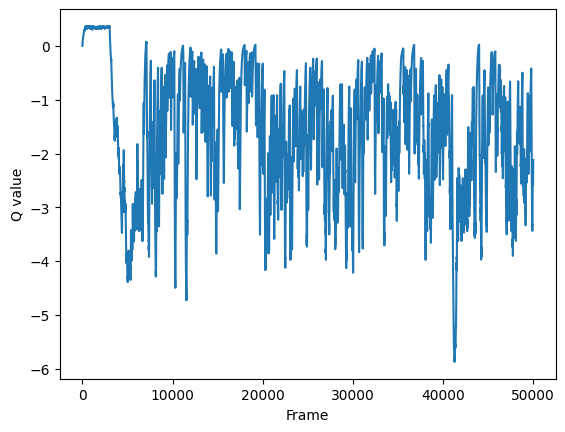

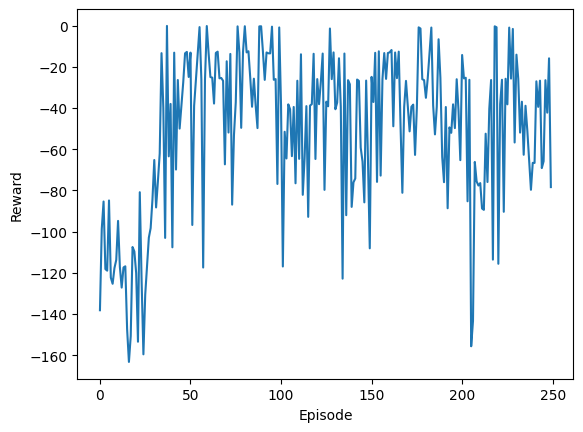

In [52]:
max_Qs_doubleDQN, returns_doubleDQN = train(isDoubleDQN = True, DQN=DQN)
# plotMaxQ(max_Qs_doubleDQN)
# plotReward(returns_doubleDQN)

100%|██████████| 50000/50000 [00:37<00:00, 1349.47it/s]


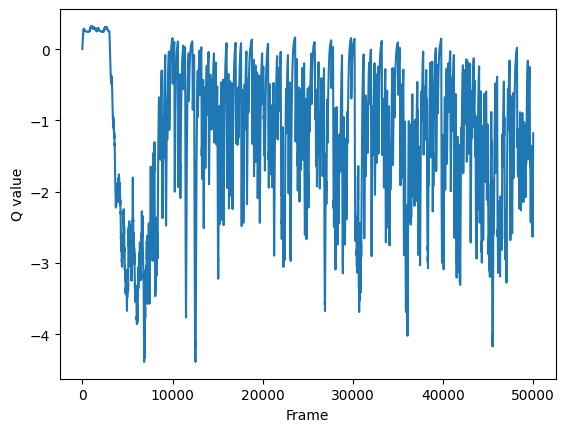

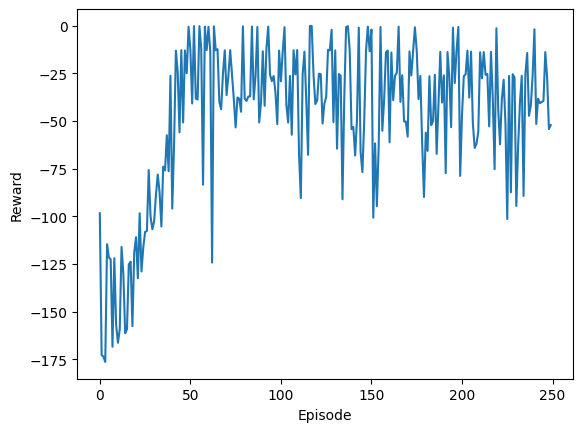

In [53]:
max_Qs_regularDQN, returns_regularDQN = train(isDoubleDQN = False, DQN=DQN)
# plotMaxQ(max_Qs_regularDQN)
# plotReward(returns_regularDQN)

In [54]:
def compareMaxQ(Q1, Q2, labels=["Double DQN", "DQN"]):
    Q1, Q2 = smooth(Q1,l=50), smooth(Q2, l=50)
    plt.xlabel("frame")
    plt.ylabel("Q value")
    plt.plot(Q1)
    plt.plot(Q2)
    plt.legend(labels)
    plt.show()
    
def compareReturn(reward1, reward2, labels=["Double DQN", "DQN"]):
    reward1, reward2 = smooth(reward1), smooth(reward2)
    plt.ylabel("Reward")
    plt.xlabel("Episode")
    minEpisode = min(len(reward1),len(reward2))
    plt.plot(reward1[:minEpisode])
    plt.plot(reward2[:minEpisode])
    plt.legend(labels)
    plt.show()

/Users/lyy/opt/anaconda3/envs/ta1/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/lyy/opt/anaconda3/envs/ta1/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


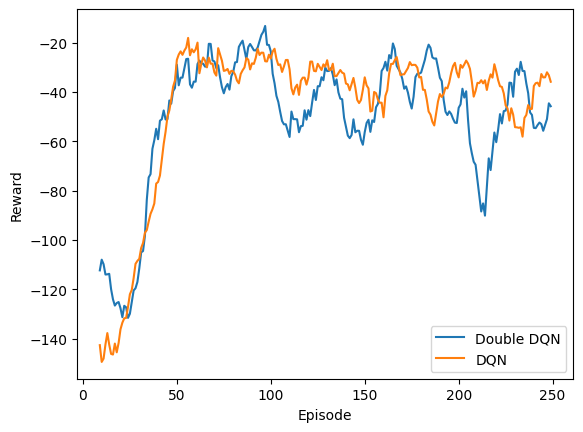

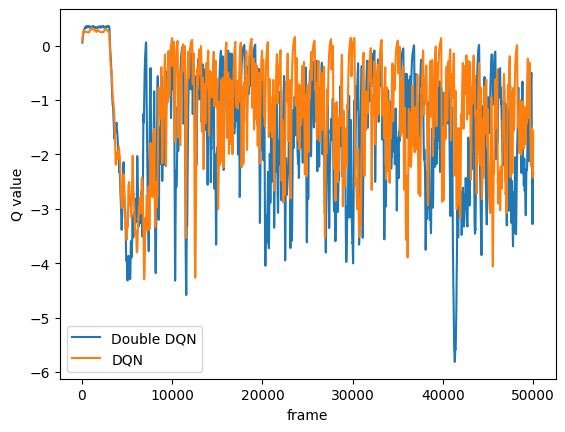

In [55]:
compareReturn(returns_doubleDQN, returns_regularDQN)
compareMaxQ(max_Qs_doubleDQN, max_Qs_regularDQN)

参考结果如下:

![Image Name](images/DoubleDQN_DQN_1.png)

![Image Name](images/DoubleDQN_DQN_2.png)


我们可以发现，相比于Double DQN，普通的DQN算法对于Q值的估计要略微高一些。

# Dueling DQN

[Dueling DQN](https://arxiv.org/abs/1511.06581)是另一种DQN的改进算法。它在传统DQN的基础上只进行了稍稍改动，但却能大幅提升DQN的表现。在强化学习中，我们将状态动作价值函数减去状态函数定义为优势函数，即$A(s,a) = Q(s,a)-V(s)$。在同一个状态下，所有动作的优势值之和为0，因为所有动作的动作价值的平均就是这个状态的状态价值。据此，在Dueling DQN中，Q网络被建模为：

$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)
$$

其中$V(s ; \theta, \beta)$为状态价值函数，而$A(s, a ; \theta, \alpha)$则为该状态下采取不同动作的优势函数，表征的是采取不同动作的差异性。$\theta$是状态价值函数和优势函数共享的网络参数，一般为神经网络用来提取特征的前几层。而$\alpha$和$\beta$为两者各自的参数。在这样的建模下我们不再让神经网络直接输出Q值，而是训练神经网络的两部分分别输出价值函数和优势函数，再求和得到Q值。DQN和Dueling DQN的网络结构图区别如下：

![DQN与Dueling DQN网络结构的区别](https://cdn.kesci.com/upload/image/qfmiegdc53.png?imageView2/0/w/320/h/320)

对于上述Dueling DQN中的公式$Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+A(s, a ; \theta, \alpha)$，它存在对于$A$值和$V$值建模不唯一性的问题（比如对于同样的$Q$值，如果将$V$值加上任意大小的常数$C$，再将所有$A$值减去$C$，则我们得到的$Q$值依然不变，这就给训练造成了不稳定）。为了解决这一问题，原论文将强制将优势函数在实际行为的输出调整为$0$，即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+\left(A(s, a ; \theta, \alpha)-\max _{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
此时可以确保$V$值建模的唯一性。
而在实际实现过程中，我们通常将优势函数在所有动作的输出期望设为$0$,即
$$
Q(s, a ; \theta, \alpha, \beta)=V(s ; \theta, \beta)+ 
\left(A(s, a ; \theta, \alpha)-\frac{1}{|\mathcal{A}|} \sum_{a^{\prime}} A\left(s, a^{\prime} ; \theta, \alpha\right)\right)
$$
这样可以提高稳定性。在下面的代码实现中，我们将采取此种方式。

**Exercise 1.**  Dueling DQN从单一的网络架构中分离出价值函数和优势函数，这种分离的直观解释是什么。并请解释为何Dueling DQN在一些环境中的表现会好于DQN。

Deuling DQN能够独立地估计状态值（价值函数）和每个动作的相对优势（优势函数）。这种分离的直观解释在于它允许算法更精细地理解环境的动态，特别是在评估每个动作的重要性上。

表现优于DQN的原因：

1. Dueling DQN将Q值分解为两个部分：状态值函数V(s)和优势函数A(s, a)。状态值函数V(s)表示在状态s下的总体价值，而优势函数A(s, a)表示采取动作a相较于其他动作在状态s下的相对优势。通过这种分解，Dueling DQN可以更清晰地区分哪些动作对状态价值的改变贡献更大，更有效地学习动作之间的差异，因此在那些具有大量相似动作、动作之间的差异性较小的环境中具有更好的表现。这使得算法能够在探索过程中更加聚焦于重要的动作，从而加速学习过程，同时也更好地泛化到新的、未见过的状态。

2. Dueling DQN能更高效学习状态价值函数。每一次更新时，函数都会被更新，这也会影响到其他动作的值。而DQN只会更新某个动作的值，其他动作的值就不会更新。因此，Dueling DQN能够更加频繁、准确地学习状态价值函数，从而提高学习效率。

# Dueling DQN代码实践
Dueling DQN与DQN相比的差异只是在网络结构上，大部分代码依然可以继续沿用，注意进行下方代码前要运行上方定义超参数的代码

In [56]:
# 注意此时多了一个参数isDuelingDQN
class DuelingDQN(DQN_base):
    def __init__(self, input_n, num_actions):
        super().__init__()

        self.input_n = input_n
        self.num_actions = num_actions
        
        # the difference
        ########################################
        ## Programming 2: 定义Dueling DQN的网络结构，建议参考上方DQN的网络结构所使用的超参数
        ########################################
        self.fc_shared = nn.Sequential(
            nn.Linear(self.input_n, 24),
            nn.ReLU()
        )
        self.fc_v = nn.Linear(24, 1)
        self.fc_a = nn.Linear(24, num_actions)
        ########################################
        ## End of Programming 2
        ########################################

    def forward(self, x):
        # the difference
        ########################################
        ## Programming 3: 实现Dueling DQN输出Q的方法
        ########################################
        v = self.fc_v(self.fc_shared(x))
        a = self.fc_a(self.fc_shared(x))
        q = v + a - a.mean(1).view(-1, 1) 
        return q
        ########################################
        ## End of Programming 3
        ########################################

以下训练预计时间：2分钟。

In [57]:
_, returns_duelingDQN = train(isDoubleDQN=False, isDuelingDQN=True, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 50000/50000 [00:45<00:00, 1107.12it/s]


In [58]:
_, returns_DQN = train(isDoubleDQN=False, isDuelingDQN=False, DQN=DQN, DuelingDQN=DuelingDQN)

100%|██████████| 50000/50000 [00:36<00:00, 1356.95it/s]


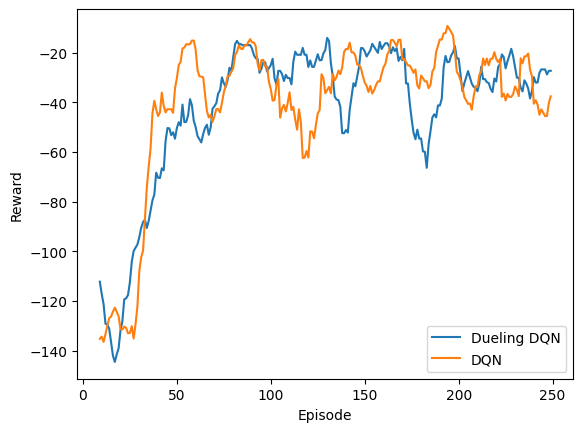

In [59]:
compareReturn(returns_duelingDQN, returns_DQN, labels=['Dueling DQN', 'DQN'])

通过曲线可以看出，相比于朴素的DQN，Dueling DQN相比于DQN在多个动作选择下的学习显得更加稳定一些。但是由于该环境较为简单，动作空间也不大，所以优势并不明显。

参考结果：

![Image Name](images/dueling_dqn.png)


# 总结
在传统的DQN基础上，有两种非常容易实现的变式——Double DQN和Dueling DQN，Double DQN解决了DQN中对Q值的过高估计，而Dueling DQN能够很好地学习到不同动作的差异性，在动作空间较大的环境下非常有效。

# 扩展阅读： 对Q值过高估计的定量分析
我们可以对Q值的过估计做一个简化的定量分析。假设在状态$s$下所有动作的期望回报均无差异，即$Q_*(s,a) = V_*(s)$（此情形是为了定量分析所简化的情形，实际上不同动作的期望回报通常会存在差异）。假设神经网络估算误差$Q_{\theta^-}(s, a)-V_{*}$服从$[-1,1]$之间的均匀独立同分布。假设动作空间大小为$m$，那么对于任意状态$s$我们有
$$
\mathbb{E}\left[\max _{a} Q_{\theta^-}(s, a)- \max_{a'} Q_{*}(s,a')\right]=\frac{m-1}{m+1}
$$
**证明：**
我们将估算误差记为$\epsilon_{a}=Q_{\theta^-}(s, a)-\max_{a'}Q_{*}(s, a')$，由于估算误差对于不同的动作是独立的，我们有
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) =\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right)
\end{aligned}
$$
$P(\epsilon_a \leq x)$是$\epsilon_a$的累积分布函数（CDF）,它可以具体被写为
$$
P\left(\epsilon_{a} \leq x\right)=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\frac{1+x}{2} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
$$
因此，我们有关于$\max_a \epsilon_a$的累积密度函数(CDF)
$$
\begin{aligned}
P\left(\max _{a} \epsilon_{a} \leq x\right) &=\prod_{a=1}^{m} P\left(\epsilon_{a} \leq x\right) \\
&=\left\{\begin{array}{ll}
0 & \text { if } x \leq-1 \\
\left(\frac{1+x}{2}\right)^{m} & \text { if } x \in(-1,1) \\
1 & \text { if } x \geq 1
\end{array}\right.
\end{aligned}
$$
最后我们可以得到
$$
\begin{aligned}
\mathbb{E}\left[\max _{a} \epsilon_{a}\right] &=\int_{-1}^{1} x \frac{\mathrm{d}}{\mathrm{d} x} P\left(\max _{a} \epsilon_{a} \leq x \right) \mathrm{d} x \\
&=\left[\left(\frac{x+1}{2}\right)^{m} \frac{m x-1}{m+1}\right]_{-1}^{1} \\
&=\frac{m-1}{m+1}
\end{aligned}
$$
虽然这一分析简化了实际环境，但它正确刻画了Q值过高估计的一些性质，比如Q值的过高估计随动作数目$m$的增加而增加，换而言之，在动作选择数更多的环境中Q值的过高估计会更严重。